In [1]:
# import pandas as pd
import cudf as pd
from tqdm.auto import tqdm
import torch


In [2]:
def import_labelled_data(path="data/level-0.5/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data



print("Loading data...")

test_dataset = import_labelled_data(path="../../data/level-0.5/irrelevant.json", )

print("Data loaded.")


# test_dataset = test_dataset.sample(5000)

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)


test_dataset.info()
test_dataset.head()

Loading data...


/workspace/GreyLit/venv/lib/python3.10/site-packages/cudf/io/json.py:108: UserWarning: Using CPU via Pandas to read JSON dataset, this may be GPU accelerated in the future
  warnings.warn(


Data loaded.
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10688 entries, 0 to 10687
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   url           10688 non-null  object
 1   text          10688 non-null  object
 2   relevance     10688 non-null  object
 3   multiclasses  10688 non-null  list
dtypes: list(1), object(3)
memory usage: 1.3+ GB


,url,text,relevance,multiclasses
0,https://documents1.worldbank.org/curated/en/56...,d e z i r o h t u A e r u s o l c s i D LEBANO...,irrelevant,[]
1,https://zooreach.org/downloads/ZOO_CAMP_PHVA_r...,Biodiversity Conservation Prioritisation Proje...,irrelevant,[]
2,https://kapelebyong.go.ug/sites/default/files/...,S R E T R A U Q D A E H T C I R T S I D G N O ...,irrelevant,[]
3,https://www.delltechnologies.com/asset/pt-pt/s...,Built for the Future of Multicloud Dell APEX C...,irrelevant,[]
4,https://www.eldercareconsultingllc.com/wp-cont...,What is the difference Why would I choose a Wh...,irrelevant,[]


In [3]:
from pickle import load

with open('models/vectorizers/hashing_vectorizer.pkl', 'rb') as f:
    vectorizer = load(f)

In [4]:
type(vectorizer)

cuml.feature_extraction._vectorizers.HashingVectorizer

In [5]:
from LogisticRegressionClassifier import LogisticRegressionClassifier

classifier = LogisticRegressionClassifier(hidden_dim=5)
classifier.load_state_dict(torch.load('models/LogisticRegression.pth'))

<All keys matched successfully>

In [6]:
classifier.state_dict()

OrderedDict([('linear.weight',
              tensor([[-2.3086e-02, -3.2679e-04, -8.6438e-03,  ..., -8.9739e-04,
                       -1.9867e-01, -1.1306e-01],
                      [-2.1175e-02, -7.4881e-04, -1.9249e-03,  ..., -7.9570e-04,
                       -2.6893e-01, -8.8998e-02],
                      [ 1.8078e-02,  1.2632e-04,  6.3343e-03,  ..., -2.9465e-04,
                        2.0814e-01,  1.1909e-01],
                      [ 2.0752e-02,  8.4350e-04,  5.5961e-03,  ...,  6.2271e-05,
                        2.1375e-01,  1.1530e-01],
                      [-1.2158e-02, -1.4964e-05, -5.6122e-03,  ...,  1.2520e-04,
                       -2.0104e-01, -1.0578e-01]], device='cuda:0')),
             ('linear.bias',
              tensor([ 0.8646,  0.9396, -0.7893, -0.6784,  0.8864], device='cuda:0')),
             ('linear2.weight',
              tensor([[-2.7859, -4.5908,  3.4179,  3.2044, -2.7999],
                      [ 2.7297,  4.7230, -3.1563, -3.6262,  2.4744]], device=

In [7]:
classifier.eval()
classifier.to('cuda:0')

torch.multiprocessing.set_start_method('spawn')
torch.set_default_device('cuda:0')
torch.cuda.set_device(0)

In [8]:
vectors = vectorizer.transform(test_dataset['text'])
labels = test_dataset['relevance'].apply(lambda x: 1 if x == 'relevant' else 0)

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /__w/cudf/cudf/python/cudf/build/cp310-cp310-linux_x86_64/_deps/rmm-src/include/rmm/mr/device/cuda_memory_resource.hpp:60: cudaErrorMemoryAllocation out of memory

In [ ]:
from LazyTextDataset import LazyTextDataset
from torch.utils.data import DataLoader


test_loader = DataLoader(LazyTextDataset(vectors, labels), batch_size=128, shuffle=False)

In [ ]:
classifier.eval()

LogisticRegressionClassifier(
  (linear): Linear(in_features=1048576, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
next(iter(test_loader))[0][0][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [ ]:
with torch.no_grad():

    y_pred = []
    y_probs = []

    for x, y in tqdm(test_loader):
        preds = classifier(x)[:,0]
        y_pred.extend(preds.argmax(dim=1))
        y_probs.extend(preds[:,1].cpu())


  0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

test_dataset['predictions'] = ['relevant' if pred==1 else 'irrelevant' for pred in y_pred]
test_dataset['score'] = y_probs.cpu()

print(classification_report(test_dataset['relevance'], test_dataset['predictions'] ))

print("Accuracy: ", accuracy_score(test_dataset['relevance'], test_dataset['predictions']))
print("Precision: ", precision_score(test_dataset['relevance'], test_dataset['predictions'], pos_label='relevant',average='macro'))
print("Recall: ", recall_score(test_dataset['relevance'], test_dataset['predictions'], pos_label='relevant',average='macro'))
print("F1: ", f1_score(test_dataset['relevance'], test_dataset['predictions'], pos_label='relevant',average='macro'))


AttributeError: 'list' object has no attribute 'cpu'

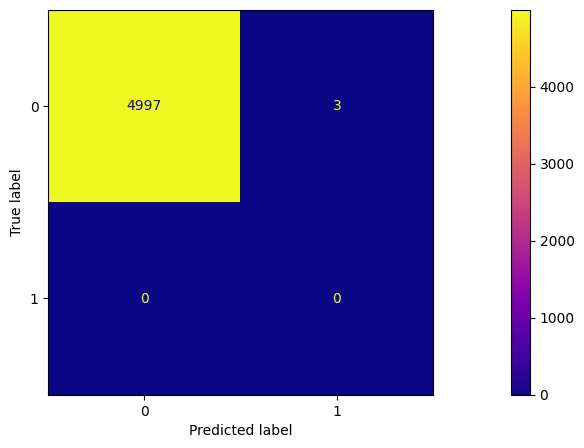

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 1, figsize=(20, 5))


confusion = confusion_matrix(test_dataset['relevance'], test_dataset['predictions'] )
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(ax=axs, cmap='plasma')

plt.show()
